# <center> Hyperdynamics with proteins:  
## <center> Using DBSCAN and SVM to define local region and bias on-the-fly </center>

<center>  Developed by Laura Watkins (University of Chicago), under the mentorship of Art Voter (Los Alamos National Laboratory)

***

## Background

**GOAL**: we want a method to get **unbiased dynamics** with **atomistic accuracy** over **long times** for proteins, with little *a priori* knowledge necessary.

Most current methods to calculate dynamical quantities (such as a rate of a protein opening and closing) require some knowledge of the system in order to set them up and get good results. Many require the definition of a "collective variable", which is a combination of system variables, such as atom positions, angles, etc, that best defines some process of interest. For example, a collective variable could be the distance between two ends of a protein to measure if it's open or closed.

<img src="images/prot.jpg" style="width: 400px;"/>

>*source: PDB 2QKM, She 2008*

Additionally, most methods used biasing techniques to calculate the underlying free energy along this collective variable (think, how much energy does it take to be at any point along the variable?). Then, dynamical quantities can be estimated from that.

Instead, this work seeks to develop a method that:

1. does not require a collective variable, but is more flexible and avoids issues with picking the wrong collective variable.

2. accurately calculates dynamic properties directly from simulations

### Hyperdynamics

Hyperdynamics (HD) is a method to **accelerate** molecular simulations.

To understand HD, first a brief note on how the molecular simulations we want to use, called molecular dynamics (MD), work. MD takes an input of atom positions and a definition of the potential energy (how each of those atoms interact with each other), and uses this potential energy to propogate the system forward in time. At each timestep, the MD engine calculates how much and where to move each atom based on the gradient of the potential energy at that time.

**Hyperdynamics** works by adding a bias potential, $\Delta$V to the normal potential V so that the system spends less time in low-energy regions, and is more likely to transition over a barrier to a different region. The key is to **bias as much as possible in the low-energy regions without touching the transition**, as shown in the example below.

<img src="images/figure-hd-delv.png" alt="Drawing" style="width: 800px;"/>

With this bias in place, we can directly calculate the time it takes to make a transition from our simulations (read up on hyperdynamics for the theory and details!)

This method works well for "hard" systems where transitions are sharp, and the bias $\Delta$V is straightforward. In complex systems like proteins, we don't know V, so choosing an exact bias is impossible. Instead, we want a method **agnostic to the underlying potential energy**.

### Choosing a bias for proteins

Here, we choose to use two angles commonly used to describe protein structures: $\phi$ and $\psi$ dihedral angles, shown below in a molecule called alanine dipeptide. This is the most commonly used "proof of concept" molecule for new methods.

These two angles describe the rotation around the two bonds indicated, and are defined for every amino acid in a protein

<img src="images/figure-diala.png" style="width: 900px;"/>

>*source:https://www.cp2k.org/exercises:2014_uzh_molsim:alanine_dipeptide ;     Vymetal, et al. JCPLett. 503 301-304, doi:10.1016/j.cplett.2011.01.030.*

The free energy plot for all possible values of these two dihedral angles is shown on the right. From this, we can tell that there are several *conformations* (ie, combinations of $\phi$ and $\psi$) this molecule likes to be in, where the plot is dark blue. Now, we want to calculate the rate of transition from one low-energy state to another--how long does the molecule spend in one conformation before moving to another? 

*Rate information can reveal a lot about how a protein works! For example, consider the big protein above--if it performs some function in one conformation but not another, knowing these rates can help us understand its mechanism*

**While we know what the low-energy regions are for this molecule, for most proteins we don't. So we also need our method to find these regions and bias them while a simulation is running.**

***

## How this new method works

### Method steps:

Setup: Run Molecular Dynamics simulation, saving all $n$ dihedral angle values.
1. Run $\Delta t$ steps
2. **Cluster** all sampled dihedral angles in $n$ dimensions
3. Use the clustering results to **define the boundary** of the current region
4. Apply bias based on distance to defined region boundary.

Repeat steps 1-4 until convergence of desired property.

In this way, when the simulation is far from the boundary, we can safely apply a higher bias. As the simulation approaches the boundary, the bias is reduced to 0 so we do not bias in important transition regions.

### Clustering

To cluster, we need a method that:
- Does not require input of # of clusters
- Allows for outliers
- Allows for non-linearity
- Uses density as primary indicator to find and define clusters

**DBSCAN** was chosen for these reasons

### Defining the boundary

**One-class SVM** was chosen to define the boundary of a given cluster. While typically this method is used to determine whether a sample point is "in" or "out" of a defined class, we're using its *distance to the decision boundary*. Critically, using a Gaussian kernel function means that this distance is differentiable, which is necessary for calculating the bias.

### Features

Using the dihedral angles directly is not ideal. These angles are periodic: $180^{\circ} = -180^{\circ}$ and regions need to be able to cross over.

Instead, we use two values $sin(\theta)$ and $cos(\theta)$ for each $\theta \in {\phi, \psi}$. These two values uniquely an angle and are periodic. Additionally, they automatically scale our input to the range $[-1, 1]$.

### This method is easily scalable to more dimensions.

***

## Example run

*Note: in this example, analysis is done as post-processing with simulation data that's already run. This is to show how the method would work if fully implemented, as a proof-of-concept*

### Setup

#### First read in data

Data is generated from 448 simulations of alanine dipeptide. Each simulation is 300000 steps long, and each step is 1 femtosecond (that's $10^{-15}$ seconds). The dihedral angles are collected every 20 steps, and we'll use every other data point.

In [12]:
import glob
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from importlib import reload  

# Package for running/processing hyperdyanmics run (example)
import hyperdynamics as hd

In [13]:
path_to_data = "trajectory-data/"
all_dihed_data = []
for run_n in range(1,449):
    data_file = "{}diala.{}.diheds.dat".format(path_to_data, run_n)
    data = np.genfromtxt(data_file, usecols=[1,2])
    all_dihed_data.append(data[::2])

#### Initialize run

Use the DihedralHD class to control our simulation. Here, we call it to initialize it before any data is added

In [14]:
sample_run = hd.hdclass.DihedralHD(2, sample_interval=0.04)

#### Let's check out our ramachandran plot 

The run has only been initialized, so it's empty as expected. We'll use these plots to monitor how the simulation is evolving, and how well our method is defining regions

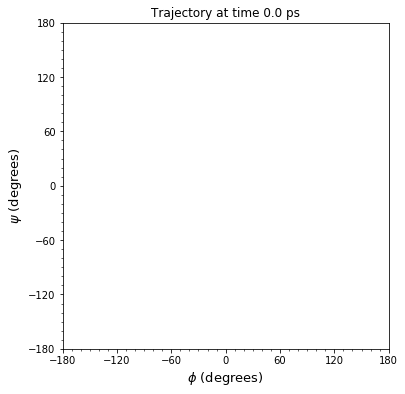

In [15]:
sample_run.plot_trajectory()

 ***

# Running the simulation

Start by examining just one trajectory, #18. Let's add the first 100 samples to see what those look like.

In [16]:
traj_n = 18
t1, t2, = 0, 100
sample_run.update_data(all_dihed_data[traj_n][t1:t2])

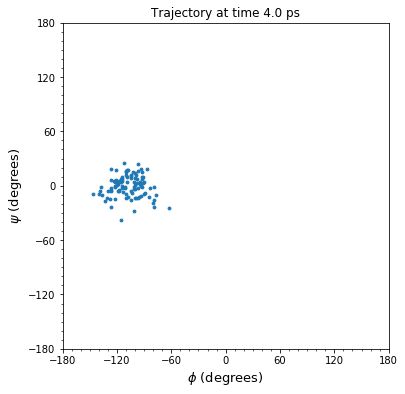

In [17]:
sample_run.plot_trajectory()

We can go ahead and see if our clustering/SVM method works

in no-man's land


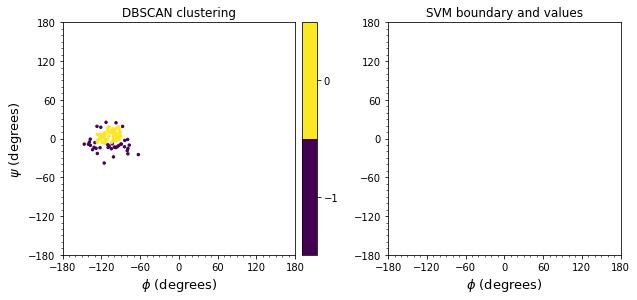

In [18]:
sample_run.update_boundary()
sample_run.plot_boundary()

It looks like DBSCAN has started to identify a region! However, the trajectory currently sits in "no-man's land" so no bias is applied and no SVM boundary is active

Add in the next 400 samples

In [19]:
t1, t2 = 100, 500
sample_run.update_data(all_dihed_data[traj_n][t1:t2])

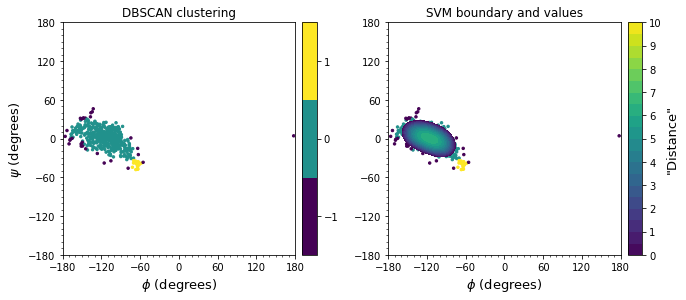

In [20]:
sample_run.update_boundary()
sample_run.plot_boundary()

DBSCAN has identified two clusters (outliers are labeled $-1$). Passing the current state (always labeled $0$) to SVM, we see that a region is defined and biases can be applied based on the distances on the right.

**Now let's see what this looks like through the rest of the trajectory, updating after every 1000 points collected**.

In [21]:
n_samples = len(all_dihed_data[traj_n])
print("We have {} total number of steps to sample".format(n_samples))

We have 7500 total number of steps to sample


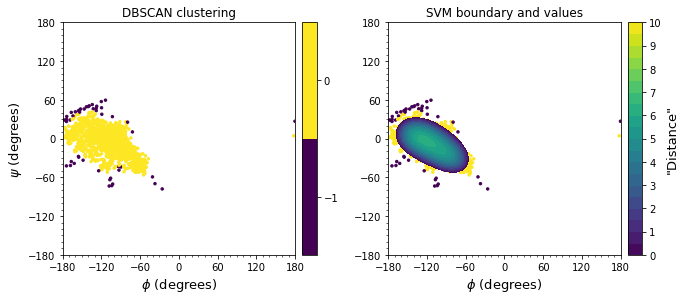

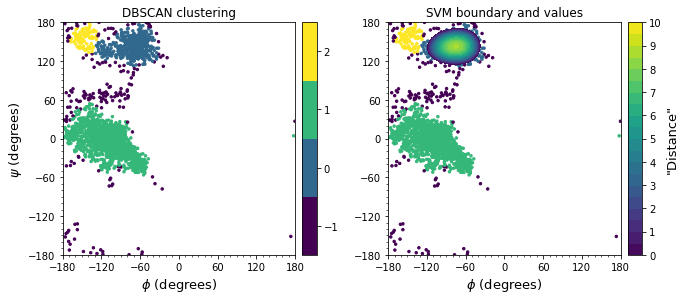

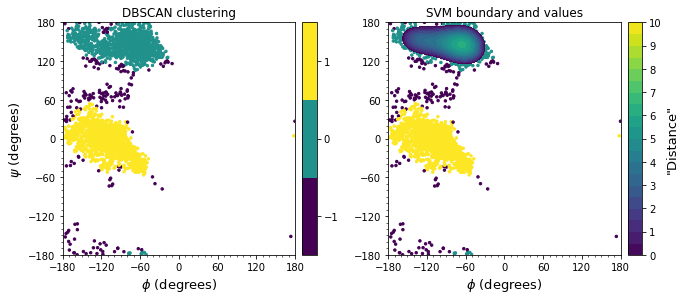

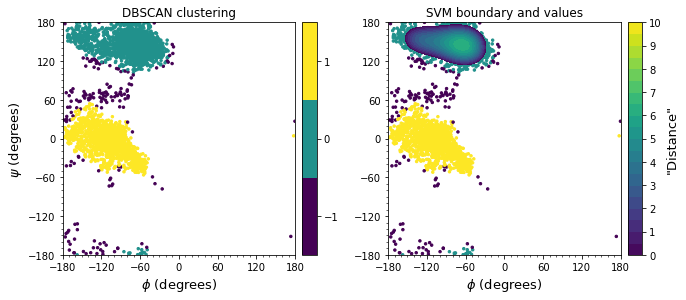

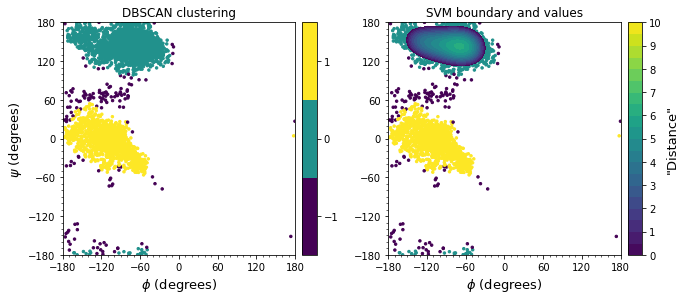

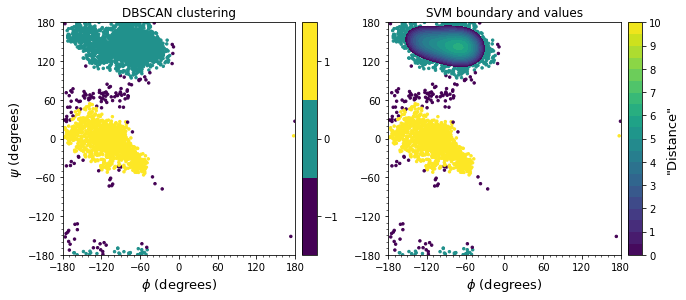

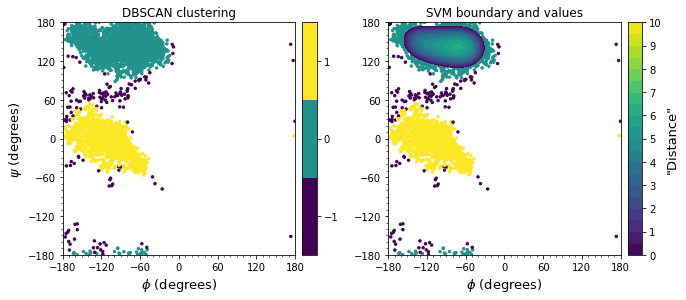

In [22]:
x = 1000
for t1 in range(500,n_samples,x):
    t2 = t1+x
    sample_run.update_data(all_dihed_data[traj_n][t1:t2])
    sample_run.update_boundary()
    sample_run.plot_boundary()

In this simulation, the molecule quickly moves to a different region in the top left of the plot. Note that as sampling increases, the region grows to reflect this--that's what we want!

In a real simulation, we would have applied a bias to the simulation that would change the sampling and ideally reduce time spent in each region. This way, we can explore more of the $\phi/\psi$ space and understand the dynamics of the molecule.

Plotting it over time:
<img src="images/gif/sample.gif" alt="Drawing" style="width: 800px;"/>

 ***

### Extending to multiple simulations

This method is easily extended to multiple simulations running simultaneously. In this case, all the sampled data would be used to cluster and find regions, and SVM boundaries would be decided for each region that a simulation is currently sampling. Here, we show the SVM results for one simulation but combine all data to determine the boundary.

In [23]:
sample_multi_run = hd.hdclass.DihedralHD(2, sample_interval=0.04, num_simulations=20)

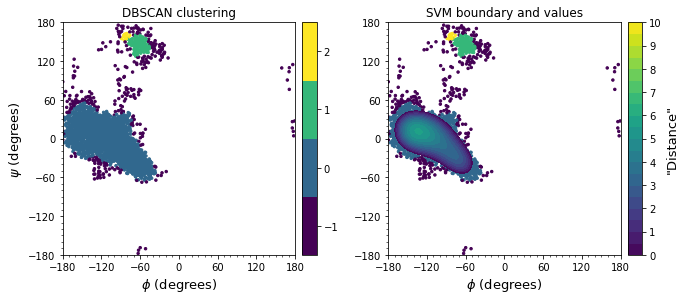

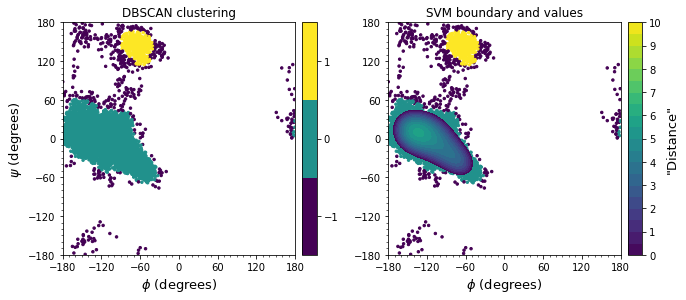

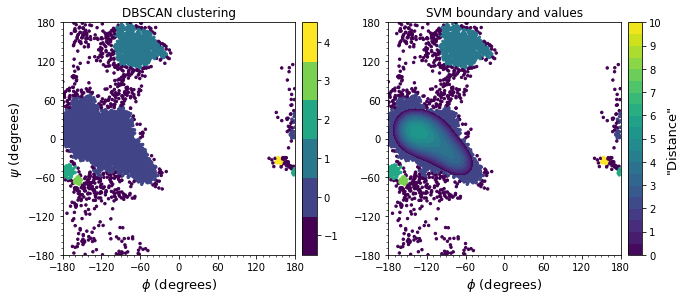

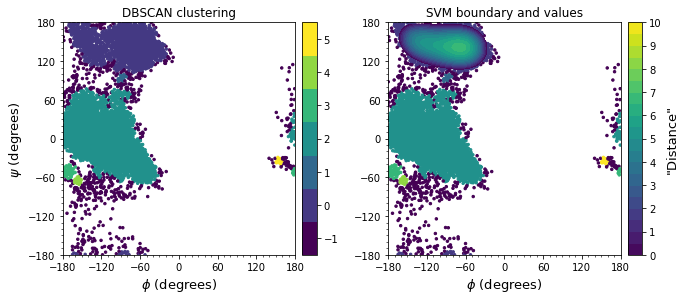

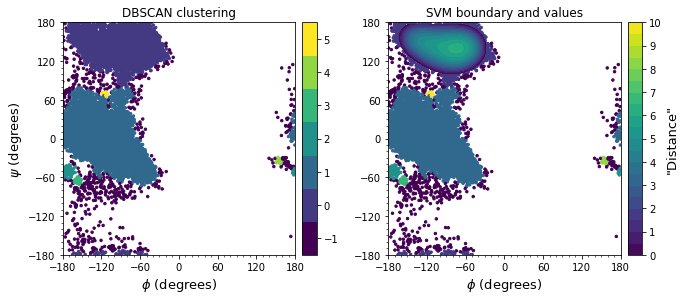

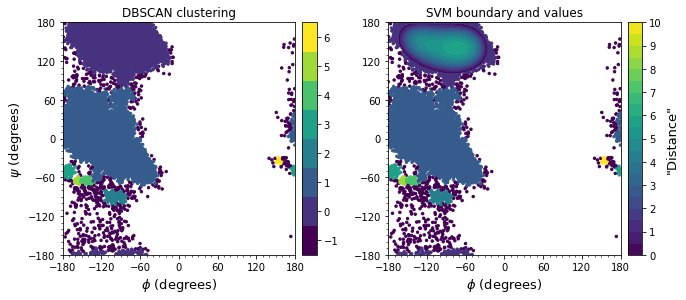

In [24]:
x = 500
for t1 in range(0,3000,x):
    t2 = t1+x
    for d in all_dihed_data[:20]:
        sample_multi_run.update_data(d[t1:t2])
    sample_multi_run.update_boundary(cluster_e=0.1, svm_n=0.05)
    sample_multi_run.plot_boundary()

***

# Next steps

This method still has a long way to go before it could be reliably implemented as a sampling technique. Immediately a few things are clear: 

1) This method is sensitive to DBSCAN and SVM parameters, particularly $\epsilon$  (e) in DBSCAN and $\nu$ (n) in SVM. These would likely need to be tuned to each system, which may be difficult in new systems where there is little intuition.

2) Additionally, we need a way to account for increasing density in transition regions with long simulations. Eventually, even if it's rare, the density becomes high enough for DBSCAN to include in a region, which we don't want. This would most easily be addressed by either adjusting the parameters as a function of simulation time and number of samples, or by subsampling the data. 

3) This is going to become more costly as simulations get longer--subsampling as mentioned in 2) could help with this.

4) Precise implementation, ie, how often to recluster and redraw boundaries, needs to be tuned.

5) Finally, obviously, this is yet not interfaced with a simulation engine. LAMMPS is a well-known, well-kept, and open-source Molecular Dynamics code that would be easy to add this to.

***

*A huge thanks to Art Voter at Los Alamos National Laboratory for his mentorship during my work on this project*